In [1]:
!git clone https://github.com/ej0cl6/deep-active-learning.git
!cd deep-active-learning

Cloning into 'deep-active-learning'...
remote: Enumerating objects: 232, done.
remote: Total 232 (delta 0), reused 0 (delta 0), pack-reused 232
Receiving objects: 100% (232/232), 44.12 KiB | 1.92 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [2]:
import sys
sys.path.append('/content/deep-active-learning')
sys.path.append('/content/deep-active-learning/query_strategies')

In [3]:
import argparse
import numpy as np
import torch
from utils import get_dataset, get_net, get_strategy
from pprint import pprint
from torchvision import datasets
import matplotlib.pyplot as plt

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
dataset = get_dataset('CIFAR10')                   # load dataset
net = get_net('CIFAR10', device)                   # load network
#strategy = get_strategy('LeastConfidence')(dataset, net)

100%|██████████| 170498071/170498071 [00:03<00:00, 56723115.64it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


#Unbalancing the dataset

In [6]:
np.unique(dataset.Y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([3986, 3986, 4048, 3984, 4003, 3975, 4020, 4023, 3997, 3978]))

In [7]:
data = dataset.X_train

In [8]:
target = dataset.Y_train

In [9]:
type(dataset), type(target) 

(data.Data, torch.Tensor)

In [10]:
target = np.array(target)

In [11]:
data.shape, target.shape

((40000, 32, 32, 3), (40000,))

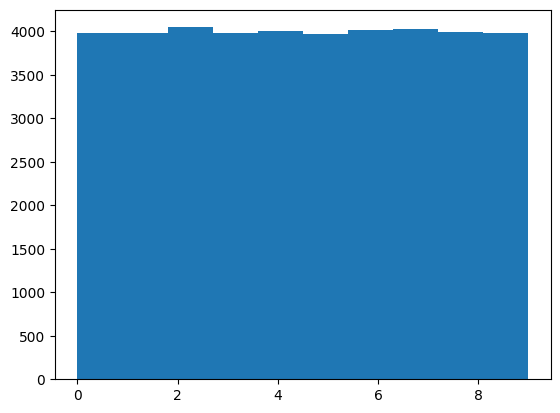

In [12]:
plt.hist(target);

In [13]:
percentage = 0
for i in range(np.unique(target).shape[0]):
    portion = np.where(target == i)[0]
    portion = portion[:int((percentage/100)*portion.shape[0])]
    data = np.delete(data, portion, axis = 0)
    target = np.delete(target, portion)
    percentage += 5
    

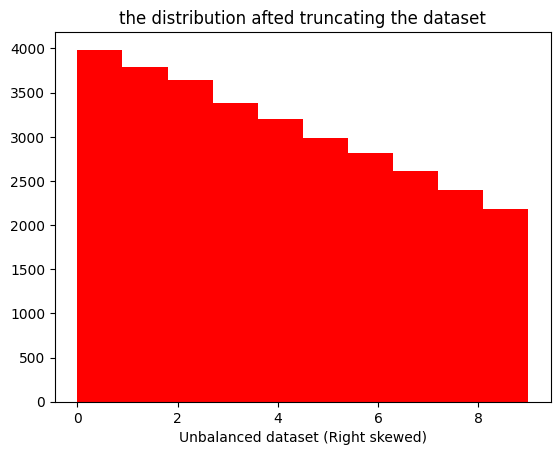

In [14]:
plt.hist(target,color = 'red');
plt.xlabel('Unbalanced dataset (Right skewed)')
plt.title('the distribution afted truncating the dataset');

In [15]:
target = torch.from_numpy(target)

In [16]:
dataset.X_train = data
dataset.Y_train = target

In [17]:
dataset.X_train.shape, dataset.Y_train.shape

((31005, 32, 32, 3), torch.Size([31005]))

In [18]:
dataset.n_pool = dataset.X_train.shape[0]
dataset.labeled_idxs = np.zeros(dataset.n_pool, dtype=bool)
net.params['n_epoch'] = 10

In [19]:
def cal_training_acc(preds):
        return 1.0 * (dataset.Y_train==preds).sum().item() / dataset.n_pool

##**Uncertainty sampling (Least Confidence) strategy**


In [20]:
strategy = get_strategy('LeastConfidence')(dataset, net)

In [21]:
# start experiment
init = 10000
dataset.initialize_labels(init)
print(f"number of labeled pool: {init}")
print(f"number of unlabeled pool: {dataset.n_pool-init}")
print(f"number of testing pool: {dataset.n_test}")
print()

number of labeled pool: 10000
number of unlabeled pool: 21005
number of testing pool: 10000



In [22]:
Test_acc_uncertainty_based_Least_Confidence_Sampling = []

In [23]:
# round 1 accuracy
print("Round 1")
strategy.train()
# no. Epoch is 10
preds = strategy.predict(dataset.get_train_data()[1])
print(f"Round 1 training accuracy: {cal_training_acc(preds)}")

preds = strategy.predict(dataset.get_test_data())
print(f"Round 1 testing accuracy: {dataset.cal_test_acc(preds)}")
Test_acc_uncertainty_based_Least_Confidence_Sampling.append(dataset.cal_test_acc(preds))

Round 1


100%|███████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.36s/it]


Round 1 training accuracy: 0.47731011127237544
Round 1 testing accuracy: 0.4629


In [24]:
for rd in range(2, 16):
    print(f"Round {rd}")

    # query
    query_idxs = strategy.query(100)

    # update labels
    strategy.update(query_idxs)
    strategy.train()

    # calculate accuracy on test and training
    preds = strategy.predict(dataset.get_train_data()[1])
    print(f"Round {rd} training accuracy: {cal_training_acc(preds)}")

    preds = strategy.predict(dataset.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
    Test_acc_uncertainty_based_Least_Confidence_Sampling.append(dataset.cal_test_acc(preds))

Round 2


100%|███████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.77s/it]


Round 2 training accuracy: 0.5710046766650541
Round 2 testing accuracy: 0.5463
Round 3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.77s/it]


Round 3 training accuracy: 0.5179164650862764
Round 3 testing accuracy: 0.4992
Round 4


100%|███████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.75s/it]


Round 4 training accuracy: 0.5495242702789873
Round 4 testing accuracy: 0.5187
Round 5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.80s/it]


Round 5 training accuracy: 0.517948717948718
Round 5 testing accuracy: 0.4938
Round 6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.97s/it]


Round 6 training accuracy: 0.3754555716819868
Round 6 testing accuracy: 0.3339
Round 7


100%|███████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.89s/it]


Round 7 training accuracy: 0.5463957426221577
Round 7 testing accuracy: 0.5171
Round 8


100%|███████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.93s/it]


Round 8 training accuracy: 0.4773746169972585
Round 8 testing accuracy: 0.453
Round 9


100%|███████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.91s/it]


Round 9 training accuracy: 0.5573294629898403
Round 9 testing accuracy: 0.5234
Round 10


100%|███████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.92s/it]


Round 10 training accuracy: 0.5196258667956781
Round 10 testing accuracy: 0.4631
Round 11


100%|███████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.02s/it]


Round 11 training accuracy: 0.5629414610546686
Round 11 testing accuracy: 0.5195
Round 12


100%|███████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.13s/it]


Round 12 training accuracy: 0.5566844057410095
Round 12 testing accuracy: 0.5278
Round 13


100%|███████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.05s/it]


Round 13 training accuracy: 0.5635542654410579
Round 13 testing accuracy: 0.546
Round 14


100%|███████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.08s/it]


Round 14 training accuracy: 0.5168521206257055
Round 14 testing accuracy: 0.4893
Round 15


100%|███████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.12s/it]


Round 15 training accuracy: 0.335397516529592
Round 15 testing accuracy: 0.314


##**Uncertainty sampling (Entropy Sampling Dropout) strategy**


In [25]:
# start experiment
init = 10000
dataset.initialize_labels(init)
print(f"number of labeled pool: {init}")
print(f"number of unlabeled pool: {dataset.n_pool-init}")
print(f"number of testing pool: {dataset.n_test}")
print()

number of labeled pool: 10000
number of unlabeled pool: 21005
number of testing pool: 10000



In [26]:
strategy = get_strategy('EntropySamplingDropout')(dataset, net)

In [27]:
Test_acc_uncertainty_based_Entropy_Sampling = []

In [28]:
# round 1 accuracy
print("Round 1")
strategy.train()
# no. Epoch is 10
preds = strategy.predict(dataset.get_train_data()[1])
print(f"Round 1 training accuracy: {cal_training_acc(preds)}")

preds = strategy.predict(dataset.get_test_data())
print(f"Round 1 testing accuracy: {dataset.cal_test_acc(preds)}")
Test_acc_uncertainty_based_Entropy_Sampling.append(dataset.cal_test_acc(preds))

Round 1


100%|███████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.53s/it]


Round 1 training accuracy: 0.6557006934365425
Round 1 testing accuracy: 0.6096


In [29]:
for rd in range(2, 16):
    print(f"Round {rd}")

    # query
    query_idxs = strategy.query(100)

    # update labels
    strategy.update(query_idxs)
    strategy.train()

    # calculate accuracy on test and training
    preds = strategy.predict(dataset.get_train_data()[1])
    print(f"Round {rd} training accuracy: {cal_training_acc(preds)}")

    preds = strategy.predict(dataset.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
    Test_acc_uncertainty_based_Entropy_Sampling.append(dataset.cal_test_acc(preds))

Round 2


100%|███████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.51s/it]


Round 2 training accuracy: 0.6017739074342848
Round 2 testing accuracy: 0.5703
Round 3


100%|███████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.44s/it]


Round 3 training accuracy: 0.6174165457184325
Round 3 testing accuracy: 0.5559
Round 4


100%|███████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.43s/it]


Round 4 training accuracy: 0.6523141428801806
Round 4 testing accuracy: 0.599
Round 5


100%|███████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.54s/it]


Round 5 training accuracy: 0.5352039993549428
Round 5 testing accuracy: 0.4923
Round 6


100%|███████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.79s/it]


Round 6 training accuracy: 0.6245121754555717
Round 6 testing accuracy: 0.5802
Round 7


100%|███████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.73s/it]


Round 7 training accuracy: 0.540041928721174
Round 7 testing accuracy: 0.4957
Round 8


100%|███████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.90s/it]


Round 8 training accuracy: 0.6094500886953718
Round 8 testing accuracy: 0.5659
Round 9


100%|███████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.89s/it]


Round 9 training accuracy: 0.6000322528624416
Round 9 testing accuracy: 0.5515
Round 10


100%|███████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.99s/it]


Round 10 training accuracy: 0.6581519109820997
Round 10 testing accuracy: 0.5973
Round 11


100%|███████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.98s/it]


Round 11 training accuracy: 0.6636348975971618
Round 11 testing accuracy: 0.6189
Round 12


100%|███████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.95s/it]


Round 12 training accuracy: 0.467698758264796
Round 12 testing accuracy: 0.447
Round 13


100%|███████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.04s/it]


Round 13 training accuracy: 0.6593452668924367
Round 13 testing accuracy: 0.6098
Round 14


100%|███████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.15s/it]


Round 14 training accuracy: 0.6338009998387357
Round 14 testing accuracy: 0.5769
Round 15


100%|███████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.10s/it]


Round 15 training accuracy: 0.6430253184970166
Round 15 testing accuracy: 0.584


##**Uncertainty sampling (Margin Sampling) strategy**


In [30]:
# start experiment
init = 10000
dataset.initialize_labels(init)
print(f"number of labeled pool: {init}")
print(f"number of unlabeled pool: {dataset.n_pool-init}")
print(f"number of testing pool: {dataset.n_test}")
print()

number of labeled pool: 10000
number of unlabeled pool: 21005
number of testing pool: 10000



In [31]:
strategy = get_strategy('MarginSampling')(dataset, net)

In [32]:
Test_acc_uncertainty_based_Margin_Sampling = []

In [33]:
# round 1 accuracy
print("Round 1")
strategy.train()
# no. Epoch is 10
preds = strategy.predict(dataset.get_train_data()[1])
print(f"Round 1 training accuracy: {cal_training_acc(preds)}")

preds = strategy.predict(dataset.get_test_data())
print(f"Round 1 testing accuracy: {dataset.cal_test_acc(preds)}")
Test_acc_uncertainty_based_Margin_Sampling.append(dataset.cal_test_acc(preds))

Round 1


100%|███████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.53s/it]


Round 1 training accuracy: 0.4547008547008547
Round 1 testing accuracy: 0.4553


In [34]:
for rd in range(2, 16):
    print(f"Round {rd}")

    # query
    query_idxs = strategy.query(100)

    # update labels
    strategy.update(query_idxs)
    strategy.train()

    # calculate accuracy on test and training
    preds = strategy.predict(dataset.get_train_data()[1])
    print(f"Round {rd} training accuracy: {cal_training_acc(preds)}")

    preds = strategy.predict(dataset.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
    Test_acc_uncertainty_based_Margin_Sampling.append(dataset.cal_test_acc(preds))

Round 2


100%|███████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.43s/it]


Round 2 training accuracy: 0.6847605224963715
Round 2 testing accuracy: 0.6223
Round 3


100%|███████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.38s/it]


Round 3 training accuracy: 0.6804063860667634
Round 3 testing accuracy: 0.6199
Round 4


100%|███████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.99s/it]


Round 4 training accuracy: 0.6755039509756491
Round 4 testing accuracy: 0.6223
Round 5


100%|███████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.79s/it]


Round 5 training accuracy: 0.6001290114497662
Round 5 testing accuracy: 0.5374
Round 6


100%|███████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.59s/it]


Round 6 training accuracy: 0.57677793904209
Round 6 testing accuracy: 0.5225
Round 7


100%|███████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.97s/it]


Round 7 training accuracy: 0.6613126915013707
Round 7 testing accuracy: 0.5994
Round 8


100%|███████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.86s/it]


Round 8 training accuracy: 0.6577648766328011
Round 8 testing accuracy: 0.5957
Round 9


100%|███████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.91s/it]


Round 9 training accuracy: 0.7041444928237381
Round 9 testing accuracy: 0.6294
Round 10


100%|███████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.84s/it]


Round 10 training accuracy: 0.6177713272052895
Round 10 testing accuracy: 0.5639
Round 11


100%|███████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.04s/it]


Round 11 training accuracy: 0.6671827124657314
Round 11 testing accuracy: 0.6009
Round 12


100%|███████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.09s/it]


Round 12 training accuracy: 0.6736332849540396
Round 12 testing accuracy: 0.6052
Round 13


100%|███████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.81s/it]


Round 13 training accuracy: 0.6862119013062409
Round 13 testing accuracy: 0.6121
Round 14


100%|███████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.78s/it]


Round 14 training accuracy: 0.6898887276245766
Round 14 testing accuracy: 0.6172
Round 15


100%|███████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.85s/it]


Round 15 training accuracy: 0.6348008385744235
Round 15 testing accuracy: 0.5732


##**Comparing results**

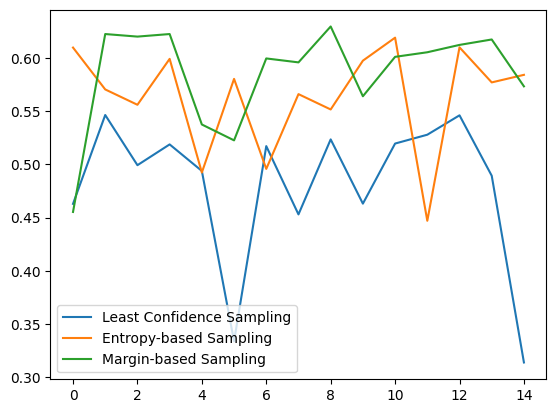

In [36]:
plt.plot(Test_acc_uncertainty_based_Least_Confidence_Sampling, label = 'Least Confidence Sampling')
plt.plot(Test_acc_uncertainty_based_Entropy_Sampling, label = 'Entropy-based Sampling')
plt.plot(Test_acc_uncertainty_based_Margin_Sampling, label = 'Margin-based Sampling')
plt.legend()
plt.show()